In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


On cherche à curl les différents types d'ARN présents dans la region 10000:200 000 du chromosome 5 des vertébrés afin d'en illustrer la diversité.

In [ ]:
%%shell

curl -s "https://rnacentral.org/api/v1/overlap/region/homo_sapiens/5:10,000-200,000" | sed -E 's/[{.*,}]/\n/g' | egrep "biotype" | cut -d ":" -f 2 | sort | uniq | sed -E 's/^"(.*[^"])"$/\1/g'
#la cmd ci-dessus permet d'obtenir les différents types d'ARN transcrits dans la région 10,000-200,000 du chromosome 5 d'H.Sapiens.


lncRNA
piRNA
sRNA
Y_RNA


Cette commande va nous servir de base afin d'automatiser l'obtention des différents types d'ARN de cette région selon différents organismes


In [ ]:
%%shell
curl -s https://rnacentral.org/help/genomic-mapping#species-with-genomic-mapping | egrep "?species=" | tr -d " " | cut -d "=" -f 3 | sed -E 's/([a-z_]*).*/\1/g' >> /content/drive/MyDrive/liste_sp_mappees-rnacentral.txt


#on récupère tout les organismes dont le génome est mappé sur rnacentral.
#on peut ainsi en faire une liste et utiliser cette liste dans la première commande à l'aide de "xargs"

In [ ]:
%%shell
#exemple d'automatisation du processus avec la commande xargs

more /content/drive/MyDrive/liste_sp_mappees-rnacentral.txt | xargs -I % curl -s "https://rnacentral.org/api/v1/overlap/region/%/5:10,000-200,000" | sed -E 's/[{.*,}]/\n/g' | egrep "biotype" | cut -d ":" -f 2 | sort | uniq | sed -E 's/^"(.*[^"])"$/\1/g' >> test.txt


Pour le déroulement de la suite, j'ai besoin de trier les espèces mappées sur rnacentral afin d'en sortir uniquement les espèces mappées au chr5 dans la région souhaitée. On va faire un peu de python


In [ ]:
import subprocess #nécessaire pour exécuter du bash

#Script pour déterminer si l'espèce a la région souhaitée ou non
index='/content/drive/MyDrive/liste_sp_mappees-rnacentral.txt'   #on ouvre notre fichier contenant les sp mappées et l'enregistre dans une liste
with open(index, 'r') as x:
    L = [line.strip() for line in x]


#trions maintenant selon l'output du chr5
#pour les tests essayons avec L2
L2=['aspergillus_niger','homo_sapiens']

for nom_sp in L[:]:      #pour tout les noms d'espèces on regarde si elles sont mappées dans cette région du chr5, sinon elles sont virées de la liste
  bash=f"curl -s https://rnacentral.org/api/v1/overlap/region/{nom_sp}/5:10000-200000 | sed -E 's/[{{.*,}}]/\\n/g' | egrep 'biotype' | cut -d ':' -f 2 | sort | uniq | sed -E 's/^\"(.*[^\"])\"$/\\1/g'"
  result = subprocess.run(bash, shell=True, capture_output=True, text=True)
  #print(result)
  if not result.stdout.strip(): #on trie selon le "stdout" qui est soit vide -> stdout='' soit rempli stdout='lncRNA\npiRNA\nsRNA\nY_RNA\n'
    L.remove(nom_sp)

#À la fin de ce script, L contient uniquement les espèces mappées.
#print(L)

index2='/content/drive/MyDrive/liste_sp_mappees.txt'

#On enregistre la list des sp mappees en .txt.
with open(index2, 'w') as liste:
    for item in L:
        liste.write(f"{item}\n")


J'ai maintenant ma liste des espèces mappées sur la région souhaitée. Je peux extraite leurs types d'ARN.

In [ ]:
import subprocess #besoin de subprocess pour exec du bash

index='/content/drive/MyDrive/liste_sp_mappees.txt'   #on ouvre la liste des sp mappées au chr5
with open(index, 'r') as x:
    L = [line.strip() for line in x]
L2=[]
for nom_sp in L[:]:
  bash=f"curl -s https://rnacentral.org/api/v1/overlap/region/{nom_sp}/5:10000-200000 | sed -E 's/[{{.*,}}]/\\n/g' | egrep 'biotype' | cut -d ':' -f 2 | sort | uniq | sed -E 's/^\"(.*[^\"])\"$/\\1/g'"
  result = subprocess.run(bash, shell=True, capture_output=True, text=True)
  L2.append([nom_sp,result.stdout.strip()])         #on crée une nvelle qui contient le nom de l'sp et ses types d'ARN sur la région chr5:10,000-200,000

#print(L2)

index2='/content/drive/MyDrive/liste_arn_et_sp.txt'

with open(index2, 'w') as liste:               #on enregistre cette nouvelle liste en .txt, elle contient toutes les données que l'on recherchait à la base.
    for item in L2:
        liste.write(f"{item}\n")

J'ai maintenant les données que je souhaite. Je vais pouvoir les analyser directement à l'aide de python ou les extraires en .csv pour utiliser d'autres logiciels de traitement de données.



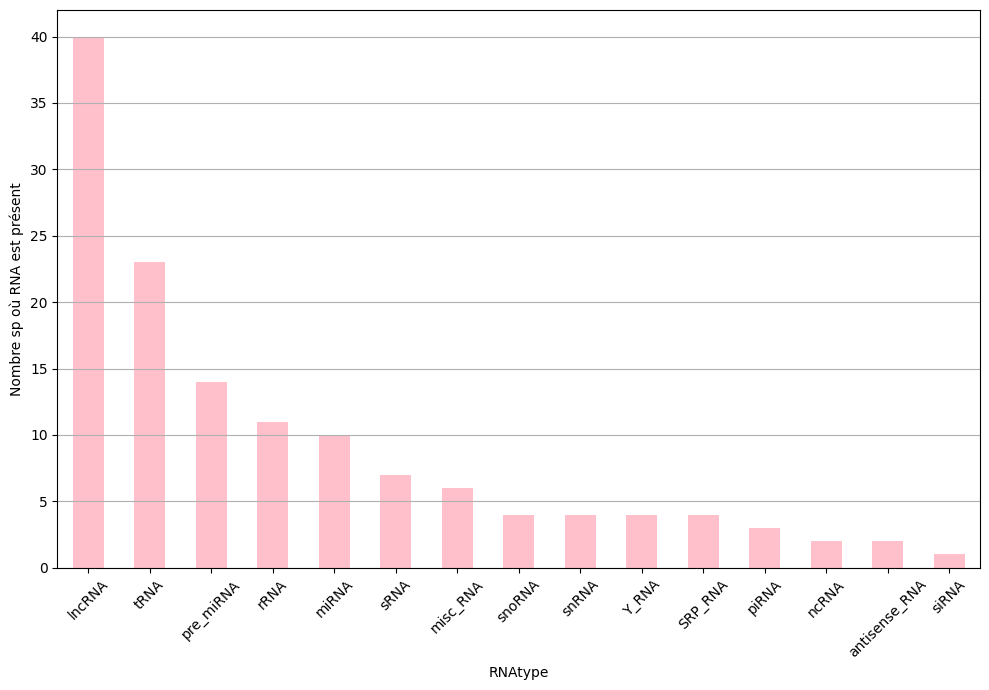

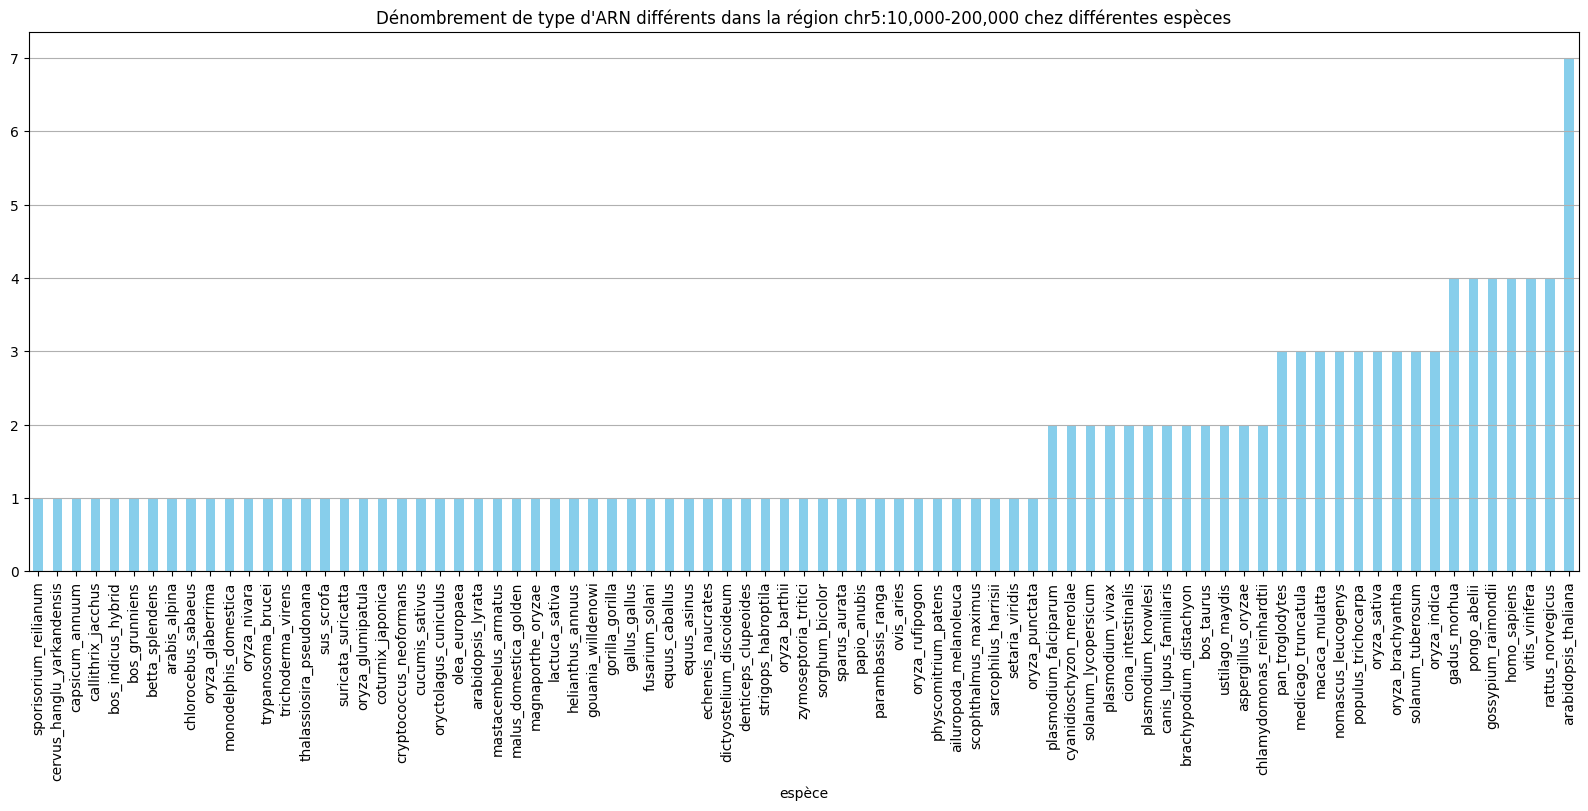

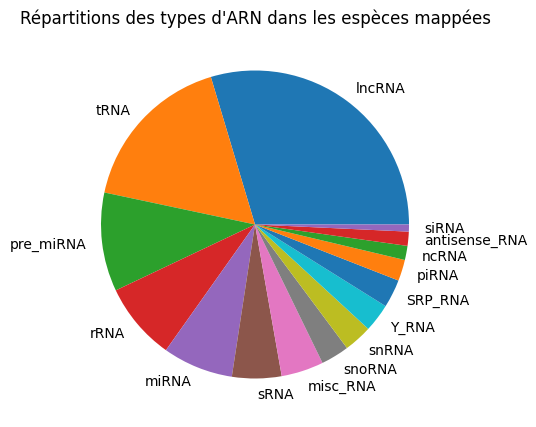

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import ast

with open('/content/drive/MyDrive/liste_arn_et_sp.txt', 'r') as file:
    lines = file.readlines()

#Convertir les lignes en listes en utilisant ast.literal_eval
data_list = [ast.literal_eval(line.strip()) for line in lines]
#print(data_list)
#Créer un DataFrame
df = pd.DataFrame(data_list, columns=['espèce', 'RNAtype'])

df['RNAtype'] = df['RNAtype'].str.split('\n')  # Séparer les types par saut de ligne
#print(df)
#df contient un tableau avec l'espèce et les types d'ARN

# On veut le dataframe avec une ligne par type d'ARN.
df_exploded = df.explode('RNAtype')
#print(df_exploded)

#df_exploded.to_csv("/content/drive/MyDrive/dataframe_chr5.csv")     #on s'enregistre le dataframe en .csv pour l'utiliser ailleurs

#Essayons de visualiser concrètement ces données avec, par exemple, un histogramme.

comptages_ARN=df_exploded['RNAtype'].value_counts()
nb_arn_par_sp=df_exploded['espèce'].value_counts()
#print(nb_arn_par_sp)
#print(comptages_ARN)
nb_arn_par_sp_croissant = nb_arn_par_sp.sort_values()

#Si on utilise pyplot pour représenter le total des différents types d'ARN.
plt.figure(figsize=(10, 7))
comptages_ARN.plot(kind='bar', color='pink') #('line', 'bar', 'barh', 'kde', 'density', 'area', 'hist', 'box', 'pie', 'scatter', 'hexbin')
plt.ylabel('Nombre sp où RNA est présent')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#Le nombre d'ARN par espèce

plt.figure(figsize=(20, 7))
nb_arn_par_sp_croissant.plot(kind='bar', color='skyblue')
plt.grid(axis='y')
plt.title("Dénombrement de type d'ARN différents dans la région chr5:10,000-200,000 chez différentes espèces")
plt.show()



#ou encore sous forme de fromage
plt.figure(figsize=(10, 5))
comptages_ARN.plot(kind='pie')
plt.ylabel('')
plt.title("Répartitions des types d'ARN dans les espèces mappées")
plt.show()
#On remarque une majorité d'ARN long non-codants.

